# Predicting Solubility of Molecules using PyCaret

For this work, we will be reproducing a research article (by John S. Delaney) by applying linear regression to predict the solubility of molecules

(`Note` solubility of drugs is an important physicochemical property in Drug Discovery, design and development)

## 1. Install Rdkit

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## 2. Delaney's solubility dataset

### 2.1 Download the dataset

In [1]:
delaney_url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv'

###  2.2 Read in the dataset

In [2]:
import pandas as pd
df = pd.read_csv(delaney_url)
df

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


## 3. Calculate molecular descriptors in rdkit

### 3.1 Convert objects into rdkit objects

In [3]:
from rdkit import Chem

In [6]:
mol_list=[]
for element in df.SMILES:
    mol = Chem.MolFromSmiles(element)
    mol_list.append(mol)

In [7]:
len(mol_list)

1144

### 3.2 Calculate molecular descriptors

To predict LogS(log of aqeous solubility), the study by delaney makes use of 4 descriptors:

1. ***cLogP***(*Octanol-water partition coefficient*)
2. **MW**(*Molecular weight*)
3. **RB**(*No. of rotatable bonds*)
4. **AP**(*Aromatic proportion= No. of aromatic atoms / total number of heavy atoms*)

Rdkit readily computes the 1st three. For the AP descriptor, we calculate this manually by computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute

In [8]:
import numpy as np
from rdkit.Chem import Descriptors

In [17]:
def AromaticProportion(m):
    aromatic_atoms = [m.GetAtomWithIdx(i).GetIsAromatic() for i in range(m.GetNumAtoms())]
    aa_count = []
    for i in aromatic_atoms:
        if i==True:
            aa_count.append(i)
    AromaticAtom = sum(aa_count)
    Heavy_Atom = Descriptors.HeavyAtomCount(m)
    AR = AromaticAtom/Heavy_Atom
    return AR

In [24]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation
def generate(smiles, verbose=False):
    
    moldata=[]
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)
    
    baseData = np.arange(1,1)
    i=0
    for mol in moldata:
        
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_MolWt = Descriptors.MolWt(mol)
        desc_NumRotatableBonds = Descriptors.NumRotatableBonds(mol)
        desc_AromaticProportion = AromaticProportion(mol)
        
        row = np.array([desc_MolLogP,
                        desc_MolWt,
                        desc_NumRotatableBonds,
                        desc_AromaticProportion])
        if (i==0):
            baseData = row
        else:
            baseData = np.vstack([baseData, row])
        i=i+1
    
    columnNames = ['MolLogP','MolWt','NumRotatableBonds','AromaticProportion']
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)
    
    return descriptors

In [25]:
X = generate(df.SMILES)

## 4. Prepare the X and Y Data Matrices

### 4.1 X matrix(computed descriptors)

In [26]:
X

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion
0,2.59540,167.850,0.0,0.000000
1,2.37650,133.405,0.0,0.000000
2,2.59380,167.850,1.0,0.000000
3,2.02890,133.405,1.0,0.000000
4,2.91890,187.375,1.0,0.000000
...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000
1140,3.42130,286.114,2.0,0.333333
1141,3.60960,308.333,4.0,0.695652
1142,2.56214,354.815,3.0,0.521739


### 4.2 Y matrix

Assigning the second column (index 1) to the Y matrix

In [28]:
Y = df.iloc[:,1]
Y = Y.rename('LogS')
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: LogS, Length: 1144, dtype: float64

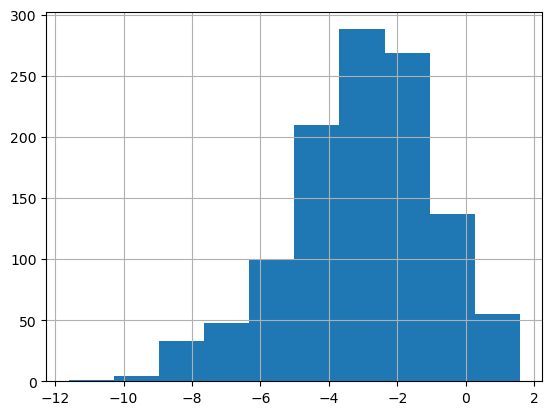

In [37]:
# Let's have a look at the distribution of this Y data
import matplotlib.pyplot as plt
Y.hist()
plt.show()

 ### 4.3 Combine X and Y into the same dataframe

In [38]:
dataset = pd.concat([X, Y], axis=1)
dataset

,MolLogP,MolWt,NumRotatableBonds,AromaticProportion,LogS
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


In [39]:
dataset.to_csv('delaney_solubility_with_descriptors.csv', index=False)

### Reference

1. John S. Delaney. ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure. **J. Chem. Inf. Comput. Sci.** 2004, 44, 3, 1000-1005.

2. Pat Walters. Predicting Aqueous Solubility - It's Harder Than It Looks. **Practical Cheminformatics Blog**

3. Bharath Ramsundar, Peter Eastman, Patrick Walters, and Vijay Pande. Deep Learning for the Life Sciences: Applying Deep Learning to Genomics, Microscopy, Drug Discovery, and More, O'Reilly, 2019.

4. Supplementary file from Delaney's ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure.

5. Scott M. Lundberg and Su-In Lee. A Unified Approach to Interpreting Model Predictions, A Unified Approach to Interpreting Model Predictions, **Advances in Neural Information Processing Systems 30 (NIPS 2017)**, 2017.